## Lab 7b: Estimating Parameters for Single Asset Geometric Brownian Motion (GBM) models
[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $S(t)$, e.g., the share price of `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$\frac{dS}{S} = {\mu}dt + \sigma{dW}$$

The constant $\mu$ denotes a drift parameter, $\sigma$ indicates a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process).  Using [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma), we can formulate an analytical solution to the GBM equation:

$$S(t) = S_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})\cdot{Z_{t}(0,1)}\Biggr]$$

where $S_{\circ}$ denotes the sharte price at $t_{\circ}$, and $Z_{t}(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) at time $t$.

## Learning bbjectives
The goal of `Lab 7b` is to help students become acquainted with using single-asset geometric Brownian motion (GBM) models. Specifically, we will use historical data to estimate the drift parameters $\mu$ and $\sigma$  in the GBM analytical solution. We'll compare the model's share price predictions for different periods to actual market values (in-sample).

### Tasks

* __Prerequisite__ (duration 5 min): Break up into teams and familiarize yourself with the lab, its setup, packages, types, functions, etc. Execute the `include("Include.jl")` command and load the data. Report back to the class any questions that your group has.
* __Task 1__ (duration 15 min): Estimate the $\mu$-parameter for each firm in the dataset. Make sure you understand the logic of how this parameter is calculated. Report back your questions.
* __Task 2__ (duration 20 min): Estimate the $\sigma$-parameter for each firm in the dataset. Make sure you understand how the $\sigma$-parameter is calculated. Report back your questions.
* __Task 3__ (duration 10 min): Pick a random firm, a random period, simulate the share price, and compare the simulation with the observed price.
    * `TODO` Build an instance of the `MyGeometricBrownianMotionEquityModel` model, inspect the fields, and ensure you understand them. 
    * `TODO` Sample the `MyGeometricBrownianMotionEquityModel` using the `sample(...)` function, and compute the `expectation` and `variance` using the analytical GBM expressions
* __Conceptual questions__: In addition to the technical tasks, please answer the conceptual questions associated with each task or subtask.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

In [1]:
include("Include.jl");

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the geometric Brownian motion simulation of equity share prices.

The mutable struct `MyGeometricBrownianMotionEquityModel`, which holds the parameters associated with the geometric Brownian motion simulation, has two fields:
* The `μ::Float64` field holds the drift or growth parameter for the model
* The `σ::Float64` field holds the volatility parameter for the model

### Functions
The `Include.jl` file also loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`function loaddatafile(; firm::Int = 1, year::String = "Year-1") -> DataFrame` 
 > The `loaddatafile(...)` function, which load historical share price data, takes an [Int](https://docs.julialang.org/en/v1/manual/integers-and-floating-point-numbers/#Integers) that encodes a `firm index` and a [String](https://docs.julialang.org/en/v1/manual/strings/) argument that holds the `year` parameter of the dataset. The historical share price data is returned to the caller as a [DataFrame](https://dataframes.juliadata.org/stable/) with the fields: `volume`,`volume_weighted_average_price`,`open`,`close`,`high`, and `low,number_of_transactions`.

`function generate_firm_index_set() -> Set{Int64}`
> The `generate_firm_index_set()` function generates the set of `firm_id` values for which we have data files for all the years of this study, i.e., `Year-1,..., Year-5`. 

`function build(model::Type{MyGeometricBrownianMotionEquityModel}, data::NamedTuple) -> MyGeometricBrownianMotionEquityModel` 
> The `build)(...)` function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(\mu, \sigma)$ values) and returns an instance of the `MyGeometricBrownianMotionEquityModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). 

`function sample(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple; number_of_paths::Int64 = 100) -> Array{Float64,2}`
> The `sample(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance, and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and solves the geometric Brownian motion model for `number_of_paths` (default: 100) trials. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`function 𝔼(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple) -> Array{Float64,2}`
> The `𝔼(...)` functions takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the expectation of the share price as a function of time. The expectation is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the expected share price. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`Var(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple)`
> The `Var(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the variance of the share price as a function of time. The variance is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the expected share price. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

### Constants
Finally, we set some constant values that are used throughtout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value) and the specify the number of trading days to simulate in the `T` variable:

In [2]:
Δt = (1.0/252.0);
T = 48;
number_of_trading_days = 1256;
all_range = range(1,stop=number_of_trading_days,step=1) |> collect;

## Prerequisite: Load historical equity dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the past five-trading years (a maximum of `1256` data points per firm). We will exclude frims that do not have the maximum number of trading days from the `dataset`. 

We load the price `dataset` by calling the `MyPortfolioDataSet()` function. This returns the `dataset` variable, which is type `Dict{Int64,DataFrame}`

In [3]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"];

The all keys array holds the list of firm indexes in the dataset that have complete data, i.e., all `1256` data values: 

In [4]:
list_of_all_firms = keys(dataset) |> collect |> sort;

## Task 1: Estimate the $\mu$ parameter
Let $\mathbf{A}$ denote a $\mathcal{S}\times{2}$ matrix, where each row corresponds to a time value. The first column of $\mathbf{A}$ is all 1's while the second column holds the $(t_{k}-t_{\circ})$ values. Further, let $\mathbf{Y}$ denote the `ln` of the price values of `firm_id` (in the same order as the $\mathbf{A}$ matrix). Then, the y-intercept and slope (drift parameter) can be estimated by solving the `overdetermined` system of equations:

$$\mathbf{A}\mathbf{\theta} + \mathbf{\epsilon} = \mathbf{Y}$$

where $\mathbf{\theta}$ denotes the vector of unknown parameters. This system can be solved as:

$$\mathbf{\theta} = (\mathbf{A}^{T}\mathbf{A})^{-1}\mathbf{A}^{T}\mathbf{Y} - (\mathbf{A}^{T}\mathbf{A})^{-1}\mathbf{A}^{T}\mathbf{\epsilon}$$

where $\mathbf{A}^{T}$ denotes the transpose of the matrix $\mathbf{A}$, and $(\mathbf{A}^{T}\mathbf{A})^{-1}$ denotes the inverse of the square matrix product $\mathbf{A}^{T}\mathbf{A}$. Finally, we can estimate the error term $\mathbf{\epsilon}$ by calculating the residuals:

$$\mathbf{\epsilon} = \mathbf{Y} - \mathbf{A}\mathbf{\theta}$$

and fitting a normal distribution to the resisduals to compute the uncertainty in the estimate of the mean of the drift parameter $\hat{\mu}$.

In [5]:
μ̂_dictionary = Dict{Int64,Float64}();
for i ∈ eachindex(list_of_all_firms)
    
    firm_index = list_of_all_firms[i];
    firm_data = dataset[firm_index];
    T_all = all_range*Δt .- Δt;
    
    A = [ones(number_of_trading_days) T_all];
    Y = log.(firm_data[!,:volume_weighted_average_price]);

    # Solve the normal equations -
    θ = inv(transpose(A)*A)*transpose(A)*Y;

    # get estimated μ -
    μ̂_dictionary[firm_index] = θ[2];
end
μ̂_dictionary;

## Task 2: Estimate the $\sigma$ parameter
There are multiple methods to calculate the volatility parameter $\sigma$. Generally, these approaches can be classified into two categories - historical volatility estimates based on return data and future volatility estimates based on the [Implied Volatility (IV)](https://en.wikipedia.org/wiki/Implied_volatility) of [put and call options contracts](https://en.wikipedia.org/wiki/Option_(finance)). For now, let's focus on computing the volatility $\sigma$ from historical data and talk about options later.

#### Historical volatility
The historical volatility is estimated by analyzing the distribution of returns. To do this, let's assume a share price model of the form:

$$
S_{j} = \exp\left(\mu_{j,j-1}\Delta{t}\right)\cdot{S_{j-1}}
$$

where $\mu_{j,j-1}$ denotes the _growth rate_ (units: 1/time) and $\Delta{t}$ (units: time) denotes the time step during the period $(j-1)\rightarrow{j}$. Solving for the return parameter $\mu_{j,j-1}$ gives the expression:

$$
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\cdot\ln\left(\frac{S_{j}}{S_{j-1}}\right)
$$

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, subsequently, it will be easier to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/365$, or $\Delta{t} = 1/252$, i.e., the fraction of a calendar or trading year that occurs in a single day (specified above).

##### Implementation
We will process each firm in the `dataset` using a `for` loop. In particular, for each iteration of the loop, we:
* We define the `σ̂_dictionary = Dict{Int64, Float64}()`, which will hold our estimates for the volatility parameter.
* Next, we for index `i`, we select a `firm_index` and `firm_data`, and compute the `growth_rate_array` for the firm. 
* We define an array that holds the values for $\mu_{j,j-1}$, named `growth_rate_array`. We then populate the `growth_rate_array` using a `for` loop; during each pass through the loop, we get values for $S_{j-1}$ and $S_{j}$, i.e., the VWAP for the two days from the dataset `firm_data`, and then compute (and store) the annualized value of $\mu_{j,j-1}$ parameter in the `growth_rate_array`.
* Finally, we approximate the historical volatility parameter $\sigma$ from the variance of the returns computed from the historical data set. In particular, we fit the return data to a `Normal` distribution using [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) and then computed an estimate of the __annualized historical volatility__ as $\sqrt{252}\cdot\hat{\sigma}$. We access the variance using the `params(...)` function.

In [6]:
σ̂_dictionary = Dict{Int64,Float64}();
for i ∈ eachindex(list_of_all_firms)
    
    firm_index = list_of_all_firms[i];
    firm_data = dataset[firm_index];

    growth_rate_array = Array{Float64,1}(undef, number_of_trading_days-1)
    for j ∈ 2:number_of_trading_days
    
        S₁ = firm_data[j-1, :volume_weighted_average_price];
        S₂ = firm_data[j, :volume_weighted_average_price];
        growth_rate_array[j-1] = (1/Δt)*log(S₂/S₁);
    end
    
    R = growth_rate_array.*Δt;
    nd = fit_mle(Normal, R);
    σ̂_dictionary[firm_index] = params(nd) |> last |> x-> *(x, sqrt(252));
end
σ̂_dictionary;

## Task 3: Visualize the simulation of a random firm for a random time period
Let's begin by selecting a `random_firm_index` from our list of firms, and get its associated data, store this in the `random_firm_data` variable:

In [14]:
random_firm_index = keys(dataset) |> collect |> rand;
random_firm_data = dataset[random_firm_index];
println("The (randomly) selected firm in this study: $(random_firm_index)")

The (randomly) selected firm in this study: 343


Next, let's randomly choose a contiguous time window of `T` days (also specified above) and analyze the model’s performance during this period. To begin, we will generate the `start_index` variable, i.e., the trading index to start the simulation from. The `stop_index` will then be determined by adding the number of trading days `T` to the `start_index`:

In [21]:
start_index = rand(1:(number_of_trading_days - T - 1))
stop_index = start_index + T
println("Visualize Firm-$(random_firm_index) between trading days ($(start_index) -> $(stop_index))")

Visualize Firm-343 between trading days (300 -> 348)


Get the $(\hat{\mu},\hat{\sigma})$ values from the respective dictionaries for the `random_firm_index`:

In [27]:
μ̂ = μ̂_dictionary[random_firm_index];
σ̂ = σ̂_dictionary[random_firm_index];
println("Firm-$(random_firm_index) has (μ̂,σ̂) = ($(μ̂),$(σ̂))")

Firm-343 has (μ̂,σ̂) = (0.04130508859950421,0.3229633151331707)


Finally, let's create a geometric Brownian motion model, using the `build(…)` function and then solve it between `T₁` and `T₂` starting with price `Sₒ` using the `solve(…)` function. 
* In addition to the analytical values of the expecxtation and trhe variance, our simulation generates `N = 100` sample paths using the `sample(...)` function, where the resulting price values are saved in the `X` array. This array will be a `T`$\times$`N+1` array,  each row corresponds to a time value, while each column (after the first) is a solution:

In [23]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

Sₒ = random_firm_data[start_index,:volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt
X = sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = 100);

For Geometric Brownian Motion (GBM) analytical expressions are available for both the expected value and the variance of the share price. The expected share price is given by:

$$\mathbb{E}\left(S_{t}\right) = S_{o}\exp\left(\mu\cdot\Delta{t}\right)$$

where $\Delta{t} = t-t_{o}$ and $S_{o}$ denotes the share price at $t=t_{o}$. On the other hand the variance of the share price $\text{Var}(S_{t})$ at time $t$ is given by:

$$\text{Var}\left(S_{t}\right) = S_{\circ}^{2}e^{2\mu\cdot\Delta{t}}\left[e^{\sigma^{2}{\Delta{t}}} - 1\right]$$

We've implmented the analytical expectation and variance calculations in the `𝔼(...)` and `Var(...)` functions:

In [24]:
expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

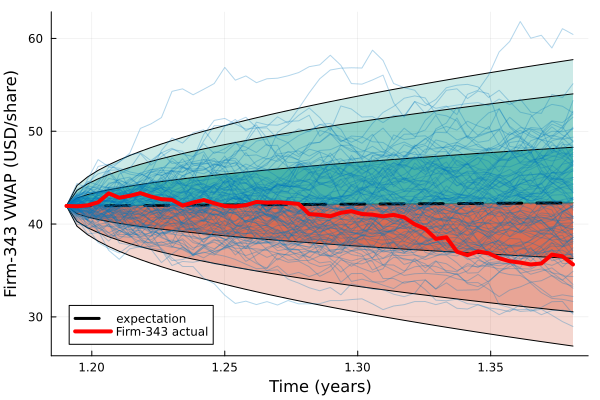

In [31]:
let
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])


    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")

    plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
    plot!(expectation[:,1], L68, c=:black, lw=1, label="")
    plot!(expectation[:,1], U68, c=:black, lw=1, label="")
    plot!(expectation[:,1], L95, c=:black, lw=1, label="")
    plot!(expectation[:,1], U95, c=:black, lw=1, label="")
    plot!(expectation[:,1], L99, c=:black, lw=1, label="")
    plot!(expectation[:,1], U99, c=:black, lw=1, label="")
    plot!(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.3)
    plot!(X[:,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(random_firm_index) actual")

    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_index) VWAP (USD/share)", fontsize=18)
end

### Was this a successful simulation?
Determining if a model accurately represents data can be done in various ways, but we will utilize a straightforward functional test. This test involves checking if the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$). 

* If the simulation meets this requirement, it is deemed a `success`. The values for $L_{j}$ and $U_{j}$ can be customized, but we set these to $\mu\pm{2.576}\cdot{\sigma}$, where $\mu$ represents the expected value and $\sigma$ is the standard deviation of the geometric Brownian motion simulation. 
* However, if the actual price exceeds the given bounds at any point, the simulation is considered a `failure`.

In [26]:
L = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
U = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])
   
# check the bounds: if below L, or above U then simulation failed
success_flag = true;
for k ∈ 1:T
    if (random_firm_data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (random_firm_data[start_index+k-1,:volume_weighted_average_price] > U[k])
        success_flag = false;
        break;
    end
end

println("The simultion of the VWAP of Firm-$(random_firm_index) between ($(start_index) -> $(stop_index)) was successful: $(success_flag)")

The simultion of the VWAP of Firm-343 between (300 -> 348) was successful: true
